In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.size"] = 18

# Transport Fundamentals

Some fundamentals beyond the life cycle of the fission neutron.

## Learning Objectives

- Calculate the dynamic impact of reactivity feedback on criticality.
- Recognize the impact of moderator material choice on reactor behavior.
- Analyze reactor behavior.
- Calculate the impact of geometry on criticality.


## Neutron Transport Fundamentals


### Fast Homogenous Reactor

Consider a reactor that is:

- fast
- critical
- the fuel and coolant are a homogeneous mixture
- the reactor has only one region, no reflector ("bare" reactor)

This reactor can be described by the one group diffusion equation:

\begin{align}
D\nabla^2\phi-\Sigma_a\phi + s &= \frac{1}{v}\frac{\partial \phi}{\partial t}\\
D &= \mbox{ the diffusion coefficient}\\
\phi &= \mbox{ flux}\\
v &= \mbox{ neutron speed}
\end{align}

If the fission source, $s$ does not balance neutron absorption and leakage, then the right hand side of the one-group diffusion equation is nonzero and the power may increase or decrease with time.

### Reactivity is deviation from k


\begin{align}
\rho &= \frac{k-1}{k}
\end{align}


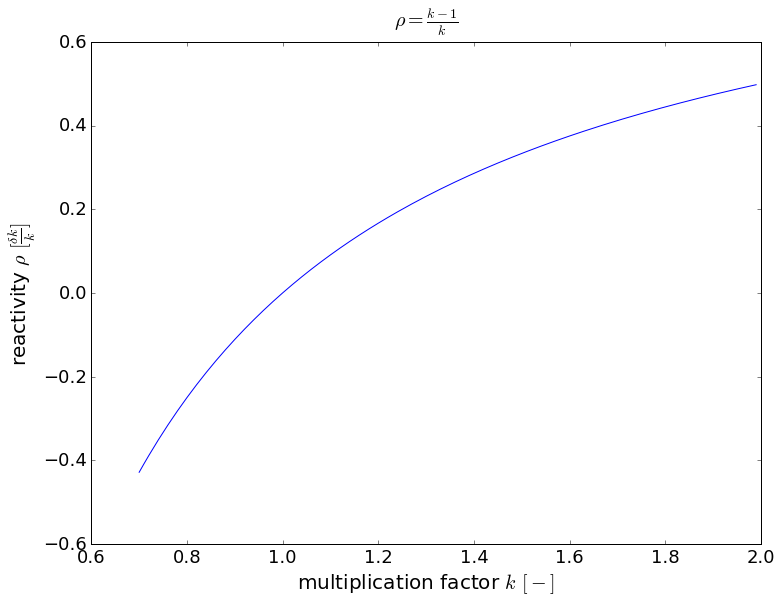

In [9]:
def rho(k):
    """reactivity, rho
    :param k: multiplication factor
    """
    return (k-1)/k

# Plot reactivity as a function of k
import numpy as np
k_vals = np.arange(0.7, 2.0, 0.01)
r = [rho(k) for k in k_vals]
plt.plot(k_vals, r)
plt.ylabel(r'reactivity $\rho$ $[\frac{\delta k}{k}]$',fontsize=20,)
plt.xlabel(r'multiplication factor $k$ $[-]$',fontsize=20,)
plt.title(r'$\rho = \frac{k-1}{k}$', fontsize=20, y=1.02)

#### Steady state

 

The multiplication factor, k, can be used to adjust the source strength and reach a steady state diffusion equation:


\begin{align}
D\nabla^2\phi-\Sigma_a\phi + \frac{1}{k}\nu\Sigma_f\phi &= 0\\
\end{align}




## Diffusion Solution

k-effective =  [ 1.00031031]
 approx alpha =  [ 0.00021715]


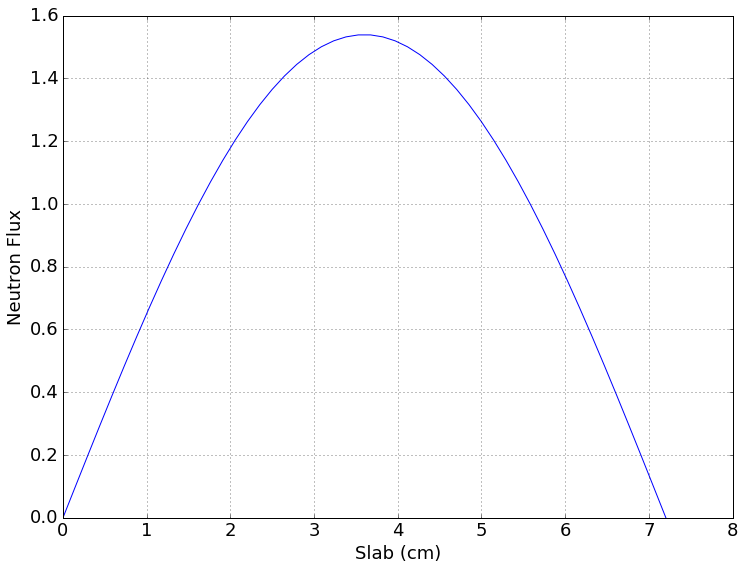

In [10]:
## This code example was adapted from
## https://github.com/marort91/AlphaEigenvalue/blob/master/RadiationTransportCoding/NeutronDiffusion_Python/NDE_CriticalityEigenvalue.ipynb

def diff(sig_tr):
    return 1.0/(3.0*sig_tr)

def sig_tr(e):
    sig_t(e) - mu*sig_s(e)

D = diff(0.1)
nusigf = 0.70
siga = 0.066    

Lx = np.pi*((nusigf-siga)/D)**(-0.5)

N = 50;
h = Lx/(N-1)

x = np.zeros(N)

for i in range(N-1):
    x[i+1] = x[i] + h
    
    
L = np.zeros((N,N))
A = np.zeros((N,N))
M = np.zeros((N,N))

for i in range(N):
    L[i][i] = L[i][i] + (-2*(-D/(h**2)))
    
for i in range(1,N):
    L[i][i-1] = L[i][i-1] + (-D/h**2)
    
for i in range(N-1):
    L[i][i+1] = L[i][i+1] + (-D/h**2)
    
for i in range(N):
    A[i][i] = A[i][i] + siga
    
M = L + A

M[0][0] = 1
M[0][1] = 0
M[N-1][N-1] = 1
M[N-1][N-2] = 0

phi0 = np.ones((N,1))
phi0[0] = 0
phi0[N-1] = 0

tol = 1e-15
k = 1.00


def is_converged(k_old, k, tol):
    return np.abs(k - k_old) <= tol

for i in range(100):
    # update k
    k_old = k
    # solve for psi
    psi = np.linalg.solve(M, nusigf*phi0)
    
    # solve for k
    k = sum(nusigf*psi)/sum(nusigf*phi0)
    
    # solve for phi
    phi0 = (1/k)*psi
    phi0[0] = 0
    phi0[N-1] = 0
    
    # determine convergence
    if is_converged(k_old, k, tol):
        break
        
plt.plot(x, phi0)
plt.xlabel('Slab (cm)')
plt.ylabel('Neutron Flux')
plt.grid()

print("k-effective = ", k)

print(" approx alpha = ", rho(k) * sum(nusigf*phi0)/sum(phi0))

### One Group Reactor Equation

We can define a quantity, geometric bucking, as:

\begin{align}
B^2 &= \frac{1}{D}\left(\frac{\nu}{k}\Sigma_f - \Sigma_a\right)\\
\end{align}

Next, we can simplify the previous equation using this definition, so that the one-group reactor equation becomes:


\begin{align}
\nabla^2\phi + B^2\phi &= 0\\
\end{align}

To find the criticality of a reactor with a specific geometry, then, we can solve the geometric buckling equation for k:

\begin{align}
k &= \frac{\nu\Sigma_f}{DB^2 + \Sigma_a}\\
\end{align}


The buckling, B, is used to help describe the geometry of the system. The solutions of the one group reactor equation for boundary conditions corresponding to canonical shapes provide both flux and buckling formulae for each canonical shape:

#### Slab
Thickness a:
\begin{align}
\phi &= cos\left(\frac{\pi x}{a}\right)\\
B^2 &= \frac{\pi^2}{a^2} 
\end{align}

#### Cylinder
Height H, Radius R:
\begin{align}
\phi &= J_0\left(\frac{\nu_0r}{R}\right)cos\left(\frac{\pi z}{H}\right)\\
B^2 &= \frac{\nu_0^2}{R^2} + \frac{\pi^2}{H^2}
\end{align}

#### Sphere
Radius R:
\begin{align}
\phi &= \left(\frac{1}{r}\right)sin\left(\frac{\pi r}{R}\right)\\
B^2 &= \frac{\pi^2}{R^2} 
\end{align}

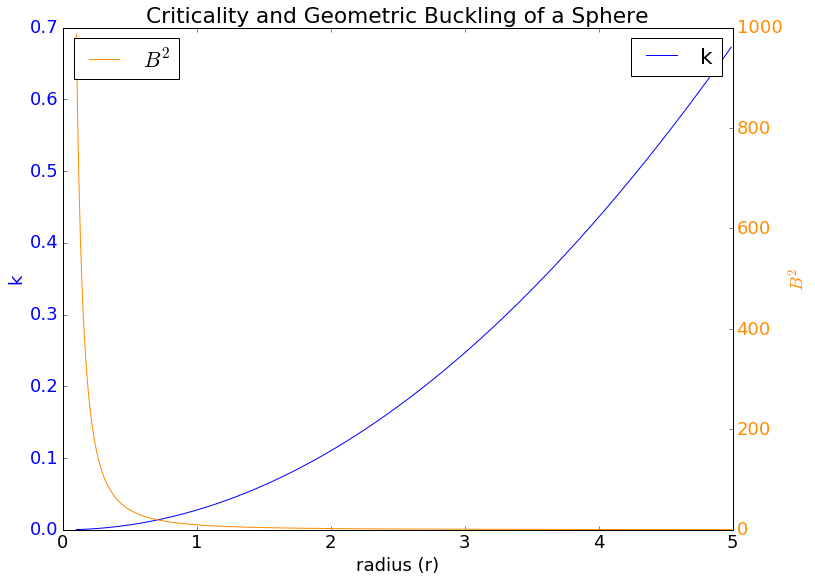

In [11]:
def k(nusigf, diff, bsq, siga):
    return nusigf/(diff*bsq + siga)


def bsq_sphere(r):
    return (np.pi**2)/(r**2)



nusigf = 0.3
diff = 1.1
siga =0.01

fig, ax1 = plt.subplots()
radii = np.arange(0.1, 5.0, 0.01)
ax1.plot(radii, k(nusigf, diff, bsq_sphere(radii), siga), 'b-', label='k')
ax1.set_xlabel('radius (r)')
ax1.set_ylabel('k', color='b')
ax1.set_title('Criticality and Geometric Buckling of a Sphere')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

    
ax2 = ax1.twinx()

ax2.plot(radii,  bsq_sphere(radii), 'darkorange', label=r'$B^2$')
ax2.set_ylabel(r'$B^2$', color='darkorange')
for tl in ax2.get_yticklabels():
    tl.set_color('darkorange')

ax1.legend()
ax2.legend(loc=2)

### Multigroup and beyond

To capture the variation of neutron energies in the diffusion equation, we can discretize the flux into energy groups.

\begin{align}
\phi &= \sum_{g=1}^{g=G}\phi_g\\
\phi_g &= \int_{E_g}^{E_{g-1}}\phi(E)dE\rvert_{g = 1,G}
\end{align}

The diffusion coefficient also needs to be individually evaluated for each energy group such that we have a $D_g$ for each group g. Also, it is important to consider possible paths of demise for potential fission neutrons. 

The derivation, based on integration, can be found in your book, pages 128-130. It is based on the following integration:

\begin{align}
\int_{E_g}^{E_{g-1}}dE\left[-\nabla D(\vec{r},E)\nabla\phi(\vec{r},E)+ \Sigma_t(\vec{r},E)\phi(\vec{r},E)\right] &= \int_{E_g}^{E_{g-1}}dE\left[\int_{E'}\Sigma_{s}(\vec{r},E'\rightarrow E)\phi(\vec{r},E') + S(\vec{r},E)\right]\\
\end{align}

Once this integration is completed for a set of group boundaries, $g\in[1,G] \rightarrow E_g\in[E_1,E_G]$, one can generically write:

\begin{align}
-\nabla D_g\nabla\phi_g+ \Sigma_{t,g}\phi_g &= \sum_{g'=1}^{g'=G}\Sigma_{s}^{g'\rightarrow g}\phi_{g'} + S\int_{E_g}^{E_{g-1}}\chi(E)dE\\
\end{align}

Recall, however, that the fission spectrum is a probability density function, so one can also write the following identities:

\begin{align}
\int_0^\infty\chi(E) &= 1\\ 
\chi_g &= \int_{E_g}^{E_{g-1}}\chi(E)dE\\ 
\sum_{g=1}^{g=G}\chi_g &= 1\\
\end{align}

This simplifies the diffusion equation:

\begin{align}
-\nabla D_g\nabla^2\phi_g+ \Sigma_{t,g}\phi_g &= \sum_{g'=1}^{g'=G}\Sigma_{s}^{g'\rightarrow g}\phi_{g'} + \chi_gS\\
\end{align}

where

\begin{align}
S &= \sum_{g'=1}^{g'=G}(\nu\Sigma_f)_{g'}\phi_{g'}
\end{align}

#### Group Removal Cross Section

The right hand side summation of the scattering cross section is confusing though. Most of the scattering is from other groups into this one, but some of the scattering is from this group into itself. Keeping that term, $\Sigma_s^{g'\rightarrow g}$ on the right hand side is misleading. It's not a source of new neutrons. So, we have a change of variables that can clean this up, the group removal cross section.


\begin{align}
\Sigma_{R,g} &= \Sigma_{t,g} - \Sigma_{s}^{g'\rightarrow g}
\end{align}

If we use the group removal cross section, then we arrivae at the following form of the multigroup equation.


\begin{align}
-\nabla D_g\nabla^2\phi_g+ \Sigma_{R,g}\phi_g &= \sum_{g'\ne G}^{g'=G}\Sigma_{s}^{g'\rightarrow g}\phi_{g'} + \chi_g\sum_{g'=1}^{g'=G}(\nu\Sigma_f)_{g'}\phi_{g'}\\
\end{align}

### Two Group Diffusion

Let's define just two groups, fast and thermal. Let's also state that all prompt neutrons are born fast and that the diffusion coefficient and cross sections do not vary in space. With these assumptions, we arrive at the following two equations:


\begin{align}
-D_1\nabla^2\phi_1 + \Sigma_{R,1}\phi_1 &= \Sigma_{s}^{2\rightarrow 1}\phi_{2} + \left[(\nu\Sigma_f)_{1}\phi_{1} + (\nu\Sigma_f)_{2}\phi_{2}\right]\\
\end{align}

\begin{align}
- D_2\nabla^2\phi_2+ \Sigma_{R,2}\phi_2 &= \Sigma_{s}^{1\rightarrow 2}\phi_{1}\\
\end{align}



**Discussion: What happened to the prompt fission spectrum, $\chi_g$ in the above equations?**

![https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/500px-Question_Mark.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/500px-Question_Mark.svg.png)

**Discussion: If we neglect upscattering, which term or terms in the above two equations will disappear?**


![https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/500px-Question_Mark.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/500px-Question_Mark.svg.png)

### Criticality calculation


For criticality calculations, one might normalize the prompt fission spectrum with k as we have done before. For simplicity, one can move the scattering term to the left hand side, as if to say "diffusion, group removal, and scattering are balanced at criticality."


\begin{align}
-\nabla D_g\nabla\phi_g+ \Sigma_{R,g}\phi_g - \sum_{g'\ne G}^{g'=G}\Sigma_{s}^{g'\rightarrow g}\phi_{g'} &= \frac{1}{k}\chi_g\sum_{g'=1}^{g'=G}(\nu\Sigma_f)_{g'}\phi_{g'}\\
\end{align}

This change propagates to the explicit equations for two groups thus:


\begin{align}
- D_1\nabla^2\phi_1 + \Sigma_{R,1}\phi_1 - \Sigma_{s}^{2\rightarrow 1}\phi_{2} &= \frac{1}{k}\chi_1\left[(\nu\Sigma_f)_{1}\phi_{1} + (\nu\Sigma_f)_{2}\phi_{2}\right]\\
\end{align}

\begin{align}
- D_2\nabla^2\phi_2+ \Sigma_{R,2}\phi_2 - \Sigma_{s}^{1\rightarrow 2}\phi_{1} &= 0\\
\end{align}





### Addition of chemical shim

Together let us consider the impact of a chemical shim, some absorber introduced to the coolant.

**Discussion: In the two group equations, which parameter will change?**


![https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/500px-Question_Mark.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/500px-Question_Mark.svg.png)


In the thermal group, group 2, the removal cross section will change, because it involves absorption. The amount of chemical shim will impact the absorption cross section thus:

\begin{align}
\Sigma_{a',2} &= \Sigma_{a,2} + \Sigma_{shim,2} \\
\Sigma_{shim, 2} &= \Sigma_{a',2} - \Sigma_{a,2}\\
&= \rho_{shim}\frac{N_{avo}}{A_{shim}}\sigma_{a,shim,2}\\
\end{align}

## Wrap-up

- Describe criticality in terms of the life cycle of a fission neutron. 
- Differentiate concepts such as neutron flux, reaction rates, cross sections, reactivity, multiplication factor.
- Calculate the multiplication factor using the 6 factor formula. 
- Calculate the dynamic impact of reactivity feedback on criticality.
- Recognize the impact of moderator material choice on reactor behavior.
- Analyze reactor behavior.
- Calculate the impact of geometry on criticality.

## References

This section was developed to complement pages YY-ZZ of [1]. 

[1] N. Tsoulfanidis, The Nuclear Fuel Cycle. La Grange Park, Illinois, USA: American Nuclear Society, 2013.
